# lstm readout branch

In [1]:
import numpy as np
import tensorflow as tf

from pureEM import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


/Users/abeukers/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## training

In [83]:
def train_loop(net,task,epochs):
#   context_emat = np.identity(net.ntrials)
  context_emat = np.random.randn(net.ntrials,net.context_edim)
  print('\n-context emat')
  print(context_emat)
  # arrays
  L = -1*np.ones(epochs)
  A = -1*np.ones(epochs)
  for ep in range(epochs): 
    T,X,Y = task.gen_episode_data()
    feed_dict = {
      net.trial_ph:T,
      net.stim_ph:X,
      net.y_ph:Y,
      net.context_emat_ph:context_emat
    }
    ops = [
      net.minimizer,
      net.train_loss,
      net.response,
    ]
    # record loss and accuracy
    outs = net.sess.run(ops,feed_dict)
    _,loss,yhat = outs

    L[ep] = loss.mean()
    A[ep] = np.mean(yhat==Y[:,2:])
  return L,A


In [251]:
ntrials = 5
nstim = 5
epochs = 10000

dim = 5

stim_edim = nstim
context_edim = ntrials


net = PureEM(nstim,ntrials,dim,stim_edim,context_edim)
task = NBackTask(nstim=nstim,ntrials=ntrials,flip_pr=.35)

non-trainable zero init
retrieve_null False feed_context_to_lstm False feed_context_to_out True
-- proportion of true trials: M=0.30 S=0.17


In [252]:
L,A = train_loop(net,task,epochs)


-context emat
[[-1.23384157  0.78866681 -0.52886771  0.3298931  -0.68607278]
 [-0.12638554  0.64097262 -0.12351245  1.89507609  1.54416412]
 [ 0.88760761 -0.01639704 -0.38333733  0.526863   -1.39829783]
 [-0.39911683  0.02636059  0.63780096 -0.23354858 -0.99236163]
 [ 1.514478    0.04717184  1.02463838  0.03095952 -0.28460119]]


Text(0.5,1,'context not trainable')

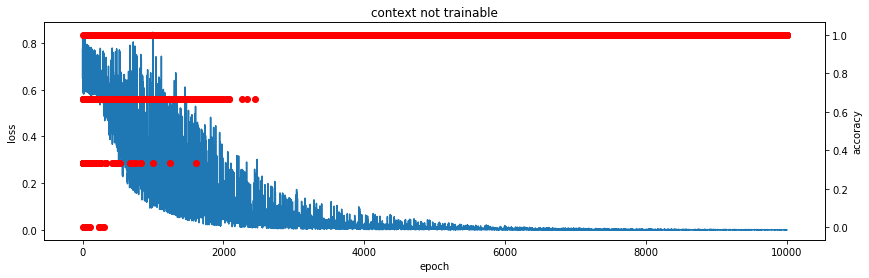

In [253]:
plt.figure(figsize=(14,4))
ax = plt.gca()
ax.plot(L)
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax2 = ax.twinx()
ax2.scatter(range(len(A)),A,c='r')
ax2.set_ylabel('accoracy')
plt.title('context not trainable')
# plt.savefig('figures/pureem-shifting_context/train_lossacc-trainable_context')


### inspect learned stim_emat

(5, 5)


array([[ 1.  , -0.03, -0.12,  0.05,  0.01],
       [-0.03,  1.  , -0.43,  0.18,  0.04],
       [-0.12, -0.43,  1.  ,  0.77,  0.15],
       [ 0.05,  0.18,  0.77,  1.  , -0.06],
       [ 0.01,  0.04,  0.15, -0.06,  1.  ]])

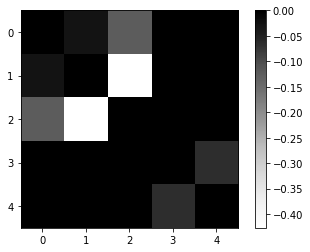

In [86]:
semat = net.sess.run(net.stim_emat)
print(semat.shape)
C = np.corrcoef(semat)
plt.imshow(C,cmap=plt.get_cmap('Greys'),vmax=0)
plt.colorbar()
C.round(2)

### inspect retrieval

In [87]:
seq = [0,1,0,2,0]
T,X,Y = task.format_seq_into_dataset(seq)
context_emat = np.identity(ntrials)
context_emat = np.random.randn(net.ntrials,net.context_edim)

feed_dict = {
  net.trial_ph:T,
  net.stim_ph:X,
  net.y_ph:Y,
  net.context_emat_ph:context_emat
}

L = net.sess.run(net.retrieved_contextsL,feed_dict=feed_dict)
L[2]

array([[[-0.11077335, -0.22799161,  0.31771746,  1.7155287 ,
          0.46887422],
        [-0.        , -0.        ,  0.        , -0.        ,
         -0.        ],
        [-1.087011  ,  0.3404636 ,  0.12392487, -1.2465123 ,
         -1.5236385 ],
        [-0.        , -0.        , -0.        , -0.        ,
          0.        ]]], dtype=float32)

In [88]:
net.sess.run(net.qksimL,feed_dict=feed_dict)

[array([ 1.0000000e+00, -7.8231096e-08], dtype=float32),
 array([-1.8626451e-08, -2.9802322e-08, -1.8626451e-08], dtype=float32),
 array([ 1.0000000e+00, -7.8231096e-08,  1.0000000e+00, -1.8626451e-08],
       dtype=float32)]

### simulating chance

proportion of true trials: M=0.39 S=0.14


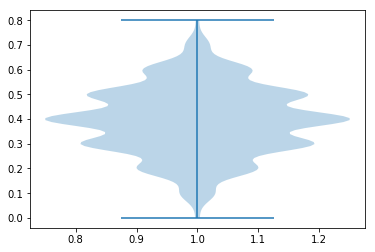

In [749]:
ntrials = 10
nstim = 5
true_nback_pr = .35
task = NBackTask(nstim=nstim,ntrials=ntrials,true_nback_pr=true_nback_pr)

L = []
for i in range(1000):
  T,X,Y = task.gen_episode()
  L.append(Y.sum()/Y.shape[1])

plt.violinplot(L)
print("proportion of true trials: M=%.2f S=%.2f"%(np.mean(L),np.std(L)))

### debugging

In [679]:
ntrials=5
net = PureEM(ntrials=ntrials,dim=2)
# task = NBackTask()
# net.reinitialize()
ntrials=5
for ep in range(1): 
  T,X,Y = task.genseq(ntrials=ntrials)
  feed_dict = {net.trial_ph:T,net.stim_ph:X,net.y_ph:Y}
  ops = [
    net.M_keys,
    net.query_key_sim,
    net.stim,
    net.retrieved_memory,
    net.M_values,
    net.context,
    net.response_in
  ]
  outs = net.sess.run(ops,feed_dict)

Tensor("strided_slice_2:0", shape=(1, 2), dtype=float32)
Tensor("strided_slice:0", shape=(2, 2), dtype=float32)
[1.0, 0.9]
Tensor("strided_slice_4:0", shape=(1, 2), dtype=float32)
Tensor("M_keys_write:0", shape=(3, 2), dtype=float32)
[0.9, 1.0, 0.9]
Tensor("strided_slice_6:0", shape=(1, 2), dtype=float32)
Tensor("M_keys_write_1:0", shape=(4, 2), dtype=float32)
[0.81, 0.9, 1.0, 0.9]


In [680]:
# stim seq
for x in X.squeeze():
  print(x)

1
2
0
2
2


In [681]:
print('cos')
print(outs[1].round(3))
# s_t

# sim

print('M_K')
print(outs[0])
print('stim_T')
print(outs[2][:,-1])
print('M_V')
print(outs[4])
print('m_T')
print(outs[3])
print('c_T')
print(outs[5][:,-1])
print('x_in')
print(outs[6].reshape(2,-1))

cos
[0.004 0.4   0.196 0.4  ]
M_K
[[ 0.11894773  0.9486887 ]
 [-0.27373168 -0.96113366]
 [-0.6422192   0.66132146]
 [-0.27373168 -0.96113366]
 [-0.27373168 -0.96113366]]
stim_T
[[-0.27373168 -0.96113366]]
M_V
[[ 0.5238827  -0.00179951]
 [-0.33924514  0.18750945]
 [-0.89836234 -0.76285404]
 [-0.7214177  -0.03025485]
 [-0.0098532   0.42147025]]
m_T
[[-0.59812367 -0.08630171]]
c_T
[[-0.0098532   0.42147025]]
x_in
[[-0.0098532   0.42147025]
 [-0.59812367 -0.08630171]]


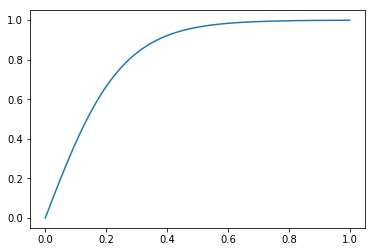

In [592]:
x = np.linspace(0,1,100)
t=4
y=np.tanh(t*x)
plt.plot(x,y)